In [1]:
# %load ../firstcell.py
%reload_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [42]:
def slope_plot(x,y,f):
    """Plot slope field of differential equation y'(t) = f(t,y).
    Assumes x and y an evenly spaced grid of 1D numpy arrays"""
    
    X, Y = np.meshgrid(x, y)
    dy = f(X,Y)
    dx = np.ones(dy.shape)

    color = dy
    lw = 1
    plt.streamplot(x,y,dx, dy, color=color, density=1., cmap='jet', arrowsize=1)

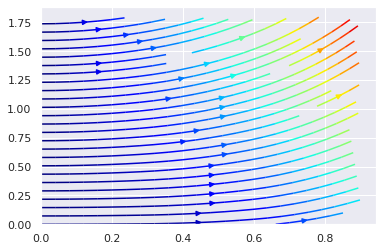

In [46]:
nx, ny = .3, .3
x = np.arange(0, 1, nx)
f = lambda t,y:t*y+t**3
y = np.arange(0, 2, ny)

slope_plot(x,y,f)

In [78]:
def Euler(function,interval,y0,num_steps):
    """Euler's method for solving initial value problems. y' = function(t,y)
    Input: interval(a tuple with initial and final points of evaluation), initial value y0 and number of steps.
    output: time steps ti and solution y
    
    Example: Euler((t0,tf),y0,100)"""
    
    h = (interval[1]-interval[0])/num_steps
    t=[interval[0]]
    y=[y0]
    for i in range(num_steps):
        t.append(t[i]+h)
        y.append(y[i]+h*function(t[i],y[i]))
    
    return np.array(t),np.array(y)

In [82]:
def f(t,y):
    return t*y+t**3
def exact_sol(t):
    return 3*np.exp(t**2/2)-t**2-2

t,y=Euler(f,(0,1),1,5)
solution = exact_sol(t)
error = abs(y-solution)

Error a paso i con tamano de paso h=0.2

In [84]:
pd.DataFrame(np.array([t,y,solution,error]).transpose(),columns=['ti','wi','yi','ei'])

,ti,wi,yi,ei
0,0.0,1.000000,1.000000,0.000000
1,0.2,1.000000,1.020604,0.020604
2,0.4,1.041600,1.089861,0.048261
3,0.6,1.137728,1.231652,0.093924
4,0.8,1.317455,1.491383,0.173928
5,1.0,1.630648,1.946164,0.315516


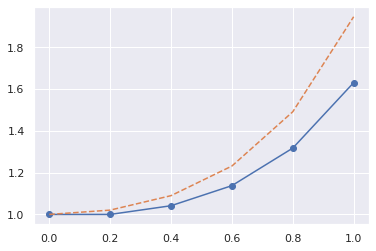

In [91]:
plt.plot(t,y,'-o',t,solution,'--')

Un sistema de primer orden es de la siguiente forma

$y^{'}_1 	= f_1 (t, y_1 , . . . , y_n )$

$y{'}_2 	= f_2 (t, y_1 , . . . , y_n )$

.
.
.

$y{'}_n = f_n (t, y_1 , . . . , y_n )$

Podmos escribir en forma vectorial:
$\frac{d\overrightarrow{r}}{dt} = \overrightarrow{f}(\overrightarrow{r},t)$

Implemento ahora Euler para un sistema de ecuaciones que es directo al pensar el sistema en forma vectorial

In [13]:
def isiterable(obj):
    try:
        iter(obj)
    except Exception:
        return False
    else:
        return True 
    
def sol_System_ODE(f,interval,r0,num_steps,method="euler",asympt=False):
    """Solving systems of initial value problems. vec{r}' = vec{f}(vec{r},t)
    where vec{r} is a vector of variables constituting the system, and the vector function f being the system
    definition. 

    Assumes that f takes an array r and time float t, f(r,t). f must return an array(r1,r2)
    
    methods: "euler", "RK4", "midpoint","leap_frog"
    
    Input: interval(a tuple with initial and final points of evaluation), a vector of initial values vec{r0} 
    and number of steps.
    output: time steps ti and solution array r_sol
    

    Example:
    
    def f(r,t):
    y1,y2 = r[0],r[1]
    return np.array([y2**2-2*y1, y1-y2-t*y2**2],float)

    interval = (0,1)
    r0 = (0,1)
    N=10
    
    sol_System_ODE(f,(t0,tf),r0,N,method="RK4")

    """
    
    assert type(method)==str and method in ["euler","RK4","midpoint","leap_frog"],\
    "Not a valid method, select one from the options."
    
    assert isiterable(r0), "Must pass an iterable of initial values and functions. If you want to\
    solve single ODE use sol_ODE instead."
    
    a,b = interval[0],interval[1]
    
    # Definition of asymptotic methods
    if asympt:
        
        def get_transf(f):
            def g(r,u):
                t = u/(1-u)
                return 1/((1-u)**2) * f(r,t)
            return g
        
        def asymptotic_transform(t):
            u = t/(1+t)
            return u
        
        a,b = asymptotic_transform(a),asymptotic_transform(b)
        
        g = get_transf(f)
        
    h = (b-a)/num_steps
    time=np.arange(a,b,h)
    r = np.array(r0,float)
    
    # los resultados se almacena en una lista para que se pueda trabajar con arrays libremente en los calculos.
    r_sol=[[],[]]
    
    def select(method):
        m=method.lower()
        def Euler_step(f,y,t):
            return h*f(y,t)
        
        def RK4_step(f,y,t):
            
            s1 = f(y,t)
            y2 = y + h*s1*0.5
            s2 = f(y2,t+h*0.5)
            y3 = y + h*s2*0.5
            s3 = f(y3,t+h*0.5)
            y4 = y + h*s3
            s4 = f(y4,t+h)
            
            return h*(s1+2*s2+2*s3+s4)/6
        
        def midpoint_step(f,y,t):
            w = f(y,t)
            y1 = y + h*w*0.5   
            
            return h*f(y1,t+h*0.5)

        def leap_frog(f,y,t):
            if abs(t - time[0])<1e-25:
                global self_start
                self_start = y + 0.5*Euler_step(f,y,t)
            self_start = self_start + h*f(y,t)
            return  h*f(self_start,t+0.5*h)

        if m == "euler":
            return Euler_step
        elif m == "rk4":
            return RK4_step
        elif m == "midpoint":
            return midpoint_step
        elif m == "leap_frog":
            return leap_frog
    
    metamethod = select(method)

    for ti in time:
        r_sol[0].append(r[0])
        r_sol[1].append(r[1])
        
        r+=metamethod(f,r,ti)
    
    if asympt:
        return time/(1-time),np.array(r_sol)
    else:
        return time,np.array(r_sol)


In [3]:
def f(r,t):
    y1,y2 = r[0],r[1]
    return np.array([y2**2-2*y1, y1-y2-t*y2**2],float)

interval = (0,1)
r0 = (0,1)
N=1000

#Analytical solution
analytical=[lambda t: t*np.exp(-2*t),lambda t:np.exp(-t)]

t,sol = sol_System_ODE(f,interval,r0,N,method="leap_frog")

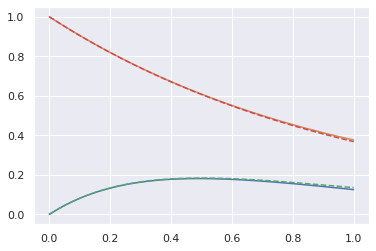

In [4]:
plt.plot(t,sol[0],t,sol[1])
plt.plot(t,analytical[0](t),'--',t,analytical[1](t),'--')


Recordar que siempre puedo convertir una ecuacion diferenecial de grado mayor a 1 a un sistema de ecuaciones diferenciales de primer orden. 


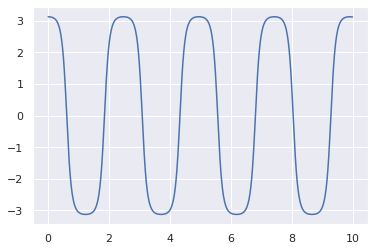

In [5]:
g=9.81
l= 0.1
def sistema(r,t):
    theta=r[0]
    omega=r[1]
    ftheta=omega
    fomega=-g*np.sin(theta)/l
    return np.array([ftheta,fomega],float)

N=1000

te,solution = sol_System_ODE(sistema,(0,10),[179/180*np.pi,0],N,'leap_frog')
plt.plot(te,solution[0])

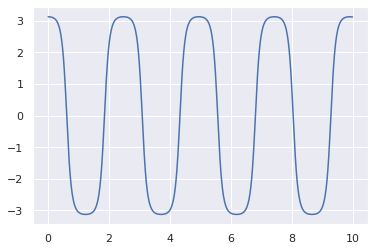

In [19]:
g=9.81
l=0.1
def f(r,t):
    theta=r[0]
    omega=r[1]
    ftheta=omega
    fomega=(-g/l)*np.sin(theta)
    return np.array([ftheta,fomega],float)

a = 0.0
b = 10.0
N = 1000
initial_ang = 179/180*np.pi

t,r = sol_System_ODE(f,(a,b),[initial_ang,0],N,method='leap_frog')
theta = r[0,:]
plt.plot(t,theta)

Text(0, 0.5, 'theta(t)')

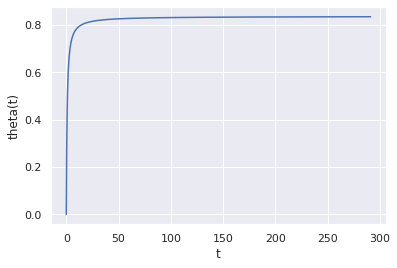

In [17]:
def pend_syst(r,t):
    y1 = r[0]
    y2 = r[1]
    f1 = y2
    f2 = F/m -y2*( k*m**2 * y1/y2 + gamma )
    return np.array([f1,f2])

a = 0.0
b = 300.0
N = 10000
F=0
k,m = 1,1
gamma = 0.01

t,r = sol_System_ODE(pend_syst,(a,b),[0,1],N,method='leap_frog',asympt=True)
theta = r[0]
plt.plot(t,theta)
plt.xlabel('t')
plt.ylabel('theta(t)')